
<h1 style="text-align: center; color: purple;" markdown="1">Econ 320 Python Assignment 1 </h1>

<h2 style="text-align: center; color: #012169" markdown="1">Effects of Education on Wages</h2>


<h3 style="text-align: center; color: #012169" markdown="1">Yuritzy Ramos</h3>

**The package set up**

In [1]:
import wooldridge as woo
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.formula.api  as smf
import scipy.stats as stats
from scipy.optimize import minimize


# Effects of education on wages
 
Download the [PSID 1982 dataset](https://www.wiley.com/legacy/wileychi/baltagi/supp/WAGES.xls) and save as a CSV. This is cross-sectional data originating from the [Panel Study on Income Dynamics](https://psidonline.isr.umich.edu/), 1982. In this assignment, we will use this data to investigate the effect of eduction on wages for this population. 

Let's first investigate our data and a few relationships in it. This is a little of what I call the "motivation" part of your regression analysis. This is very simple- you will have to do more involved things in your final project. 

* First, Google PSID1982 to see what each variable means. Find the path of where you save this data set in your computer and import it into your Jupyter notebook.

* Then create two tables to show the proportion of women and men in the dataset and the proportion of people that reside in a standard metropolitan statistical area. 

* Create a third table, the cross reference table for these two variables.  

In [2]:
# import csv 
PSID1982 = pd.read_csv("PSID1982.csv")

In [3]:
table1_pd = PSID1982['gender'].value_counts()
print(f'freq table: \n{table1_pd}\n')

print(f'Proportion table: \n{table1_pd/table1_pd.sum()}\n')


freq table: 
male      528
female     67
Name: gender, dtype: int64

Proportion table: 
male      0.887395
female    0.112605
Name: gender, dtype: float64



In [4]:
table2_pd = PSID1982["smsa"].value_counts()
print(f'freq table: \n{table2_pd}\n')
print(f'freq table: \n{table2_pd/table2_pd.sum()}\n')

freq table: 
yes    382
no     213
Name: smsa, dtype: int64

freq table: 
yes    0.642017
no     0.357983
Name: smsa, dtype: float64



## Let's add a cross table 

In [5]:
crosstab = pd.crosstab(PSID1982["gender"], PSID1982["smsa"], normalize = True)
crosstab

smsa,no,yes
gender,,
female,0.023529,0.089076
male,0.334454,0.552941


* The following table looks at the correlation table between wages education and experience. 
* What can you say about this correlations? Do they have the expected sign?

In [6]:
# load data named <dataset> and save it in an object with the same name
cormat = PSID1982[['wage', "education", "experience"]]

cormat.corr().round(decimals=3)

#Comments on correalations 
#The correlations make some sense in context of the possible relationship 
#between wage, education, and experience
#For example, more education is expected to have a positive correlation on wage
#Having more experience also has a positive correlation on wage which is also expected
#Then there is the negative corelation between experience and education which also makes sense since
#individuals with less education may find it difficult to gain opportunities for valuable experience

,wage,education,experience
wage,1.000,0.441,0.090
education,0.441,1.000,-0.222
experience,0.090,-0.222,1.000


## Find averages of relevant variables and some statistics by gender


1. Look at the averages for the whole sample for wage, education, and experience

2. Calculate the above averages, now separated by gender. Add the correlation between wage and education by gender.  


* What can you say about these results? 

* What can you say about the average values for women vs men? 

In [7]:
eductable = PSID1982[['wage', "education", "experience"]].mean()
eductable = pd.DataFrame(round(eductable,3), columns = ["Averages"])
eductable

,Averages
wage,1148.039
education,12.845
experience,22.854


In [8]:
bygender = PSID1982.pivot_table(values=["education", "experience", "wage"], index="gender", aggfunc=[np.mean])
PSID1982.groupby('gender')[['wage','education']].corr()
bla = PSID1982.groupby(['gender'])[['wage','education']].corr().iloc[0::2,-1].values[0::1]
bygender['corrwage_educ'] = bla
bygender

#Education and experience seems to be the same for men and women 
#while there appears to be a bigger difference between the wages earned by men vs. women


mean                         corrwage_educ
        education experience         wage              
gender                                                 
female  12.835821  20.014925   735.820896      0.670763
male    12.846591  23.214015  1200.346591      0.449465

# Graphs 

Let's look at those numbers using graphs. 

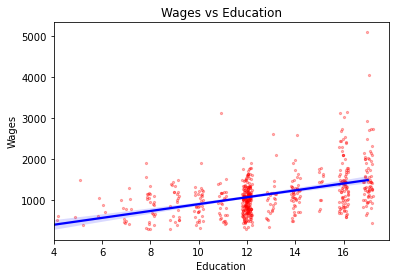

In [9]:
# use line_kws= {'color':'blue'} to change color of the line
# scatter_kws={'color':'red', 's':5} to change color and size of dots

sns.regplot(x="education", y="wage", data=PSID1982,line_kws= {'color':'blue'},marker='o',
           scatter_kws={'color':'red', 's':5, 'alpha':0.3}, x_jitter = 0.2).set(title= 'Wages vs Education',
                                                  xlabel="Education", ylabel = "Wages");


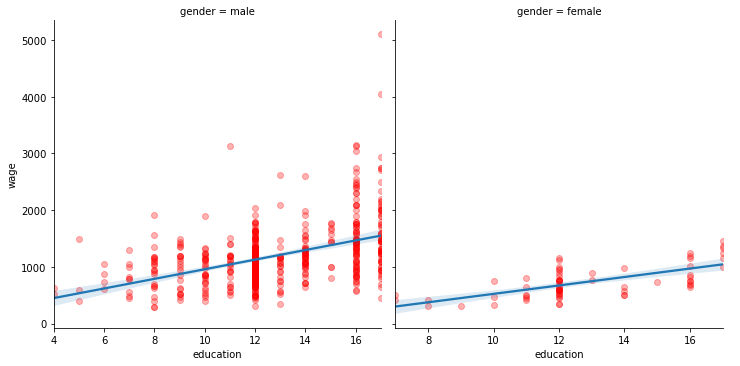

In [10]:
 sns.lmplot(x="education", y="wage", col="gender", scatter_kws={'color':'red','alpha':0.3}, 
            sharex=False,  data=PSID1982).add_legend();

# Simple regression analysis

Now let's use the data to estimate the following equation
$$ wage = \beta_0 + \beta_1*education + u $$

Estimate this equation using the step by step method learned last class, the method that minimizes SSR and the variance covarance method. (3 ways first)

### Equation system results: step-by-step

In [11]:

y = PSID1982["wage"]
x = PSID1982["education"]

# ingredients to the OLS formulas:


sumy = np.sum(y)
sumxy = np.sum((x-np.mean(x))*(y-np.mean(y)))
sumx2 = np.sum((x-np.mean(x))**2)
sumy2 = np.sum((y-np.mean(y))**2)
x_bar = np.mean(x)
y_bar = np.mean(y)




# manual calculation of OLS coefficients:
b1 = sumxy/sumx2
b0 = y_bar - b1 * x_bar

print(f'b1: {b1}\n')
print(f'b0: {b0}\n')

b1: 83.88785655141531

b0: 70.4674157605591



### Function minimization results 


In [12]:
#Create initial values for the Beta parameters
b = np.array([0.5, 0.5])

#create a column of constants
k= np.ones(len(x))

# Create function for Sum of square residuals (SSR)
def sse(b,y,x,k):
    return np.sum((y-b[0]*k-b[1]*x)**2)

#Use minimize from scipy.optimize to find the parameters beta that minimize the SSR
resa = minimize(fun = sse, args = (y,x,k), x0 = b) # beta 

# print results
print(resa['x'])

[70.46925847 83.88772698]


### Covariance , variance method
Using the `np.cov(x,y)` and `np.var(x)` functions in Python calculate the $\hat\beta_0, \hat\beta_1$ based on the equation below.
$$\hat\beta_1=\frac{Cov(x,y)}{Var(x)}$$ 
$$\hat\beta_0 = \bar{y} - \hat\beta_1 \bar{x}$$

In [13]:
# ingredients to the OLS formulas:
cov_xy = np.cov(x,y)[1,0]  # access 2. row and 1. column of covariance matrix
var_x = np.var(x, ddof=1)
x_bar = np.mean(x)
y_bar = np.mean(y)

# manual calculation of OLS coefficients:
b1 = cov_xy / var_x
b0 = y_bar - b1 * x_bar

print(f'b1: {b1}\n')
print(f'b0: {b0}\n')

b1: 83.8878565514152

b0: 70.4674157605607



### `ols()` command 

Finally use the `ols()` command to estimate save your estimation in an object called reg and show the summary of your model. 
$$ log(wage) = \beta_0 + \beta_1*education + u $$
What can you say about this new results why is it better to use $log(wages)$?
What is your interpretation of the coeficients and the $R^2$?

In [14]:
# estimate log-level model:
data = {"x": PSID1982["education"], "y": np.log(PSID1982["wage"]) }
# Put all vectors into a data frame to work with it later 
# and becasue you need that format for the graphs
datas = pd.DataFrame(data)
reg = smf.ols(formula = 'y ~ x', data=datas)
results = reg.fit()

# print results using summary:
print(f'results.summary(): \n{results.summary()}\n')

#Interpreting results 
# They appear to be more accuarte
# It's better to use log(wage) because it makes more sense for the wages
# to increase by a certain percentage in relation to an increase in education
# The R-squared value implies that 20.8% of the variation in y is explained by x

results.summary(): 
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.208
Model:                            OLS   Adj. R-squared:                  0.207
Method:                 Least Squares   F-statistic:                     156.2
Date:                Wed, 22 Dec 2021   Prob (F-statistic):           5.64e-32
Time:                        20:07:52   Log-Likelihood:                -283.58
No. Observations:                 595   AIC:                             571.2
Df Residuals:                     593   BIC:                             579.9
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      6.0292      0.075

<style>
div.gray { background-color:#dbdbdb; border-radius: 5px; padding: 20px;}
</style>
<div class = "gray">

**Packages used in this document**

`wooldridge`
`matplot.lib`
`pandas`
`numpy` 
`seaborn`
    

</div>

&nbsp;
<hr />
<p style="font-family:palatino; text-align: center;font-size: 15px">ECON320 Python Programming Laboratory</a></p>
<p style="font-family:palatino; text-align: center;font-size: 15px">Professor <em> Paloma Lopez de mesa Moyano</em></a></p>
<p style="font-family:palatino; text-align: center;font-size: 15px"><span style="color: #6666FF;"><em>paloma.moyano@emory.edu</em></span></p>

<p style="font-family:palatino; text-align: center;font-size: 15px">Department of Economics</a></p>
<p style="font-family:palatino; text-align: center; color: #012169;font-size: 15px">Emory University</a></p>


&nbsp;

In [ ]:
!jupyter nbconvert --to html nameoffile.ipynb